In [102]:
from rdchiral.template_extractor import extract_from_reaction
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from cgr.ml import scrub_anonymous_template_atoms, sep_aidx_to_bin_label
from ergochemics.mapping import rc_to_nest
from ergochemics.draw import draw_molecule
from IPython.display import display, SVG

from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

metrics = {
    'precision': precision_score,
    'recall': recall_score,
    'accuracy': accuracy_score,
    'f1': f1_score
}

In [88]:
def get_rdchiral_preds(rdchiral_template: str, lhs: str, bin_labels: np.ndarray) -> np.ndarray:
    '''
    Performs substructure matching of rdchiral template against the lhs block molecule
    and returns rdchirals predictions in binary format for the highest scoring of the matches.
    '''
    patt = Chem.MolFromSmarts(rdchiral_template)
    lhs_mol = Chem.MolFromSmiles(lhs)
    if lhs_mol is None or patt is None:
        return None
    matches = lhs_mol.GetSubstructMatches(patt)
    if len(matches) == 0:
        return None
    
    best_y_pred = None
    best_acc = 0
    for match in matches:
        _y_pred = np.zeros(bin_labels.shape, dtype=int)
        _y_pred[list(match)] = 1
        _acc = np.equal(_y_pred, bin_labels).sum()
        # _acc = recall_score(bin_labels, _y_pred)

        if _acc > best_acc:
            best_acc = _acc
            best_y_pred = _y_pred
    
    return best_y_pred

In [89]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    fps = compose(config_name="filepaths")

In [90]:
mechinfo_maps = pd.read_parquet(
    Path(fps.raw_data) / "mapped_known_reactions_x_mechinformed_rules.parquet"
)
mechinfo_maps["template_aidxs"] = mechinfo_maps["template_aidxs"].apply(rc_to_nest)
mechinfo_maps['template_aidxs'] = mechinfo_maps.apply(lambda x: scrub_anonymous_template_atoms(x.template_aidxs, x.rule), axis=1) # Scrub anonymous atoms from aidxs
mechinfo_maps["binary_label"] = mechinfo_maps.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs)[0], axis=1) # Convert aidxs to binary labels for LHS block mol
mechinfo_maps.head()

,rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id,binary_label
0,4fc554b86bb64504ce3bb78f4c02accc82779129,*C#N.O>>*C(N)=O,[*:4][C:1]#[N:2].[OH2:3]>>[*:4][C:1]([NH2:2])=...,[C&D2&v4&H0&+0&!R&z2:1]#[N&D1&v3&H0&+0&!R:2].[...,"(((1, 2), (0,)), ((1, 2, 3),))",101,"[[0.0], [1.0], [1.0], [1.0]]"
1,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,*C(=O)C(*)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP...,[*:3][C:1](=[O:2])[CH:4]([*:5])[C:6](=[O:7])[O...,[C&D3&v4&H0&+0&!R&z2:1]=[O&D1&v2&H0&+0&!R:2].[...,"(((1, 2), (3, 4, 5, 45, 46, 47)), ((1, 2), (3,...",452,"[[0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0...."
2,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C...,[*:21][P:18](=[O:22])([OH:23])[O:15][CH2:11][C...,[*:1](~[O&D1&v2&H1&+0&!R:2])~[*:3]~[O&D2&v2&H0...,"(((20, 22, 23, 24), (5,)), ((20, 22), (5, 6, 7)))",722,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
3,c82512d7ba8569c1c44dfb76137b3fea52ee6271,*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C...,[*:21][P:18](=[O:22])([OH:23])[O:15][CH2:11][C...,[*:1](~[O&D1&v2&H1&+0&!R:2])~[*:3]~[O&D2&v2&H0...,"(((20, 22, 23, 24), (5,)), ((20, 22), (5, 6, 7)))",722,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,1df0c98f185e6581109d26af4be03ea93c490d63,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:4][C:1](=[O:2])[S:10][CH2:11][CH2:12][NH:...,[C&D3&v4&H0&+0&!R&z2:1](=[O&D1&v2&H0&+0&!R:2])...,"(((1, 2, 3), (5,)), ((5, 6, 8), (47,)))",39,"[[0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...."


In [91]:
id = 'cd01daf75dd6555ddced162027e44974a23d725d'
sma = mechinfo_maps.loc[mechinfo_maps['rxn_id'] == id, 'am_smarts'].values[0]
y = mechinfo_maps.loc[mechinfo_maps['rxn_id'] == id, 'binary_label'].values[0]
sma

'[O:53]=[C:52]([OH:51])[CH2:1][CH:2]([OH:3])[C:4](=[O:5])[OH:6].[NH2:14][C:13](=[O:15])[c:7]1[cH:12][cH:11][cH:10][n+:9]([CH:16]2[O:17][CH:19]([CH2:22][O:24][P:25](=[O:26])([OH:27])[O:28][P:29](=[O:30])([OH:31])[O:32][CH2:33][CH:34]3[O:35][CH:37]([n:40]4[cH:42][n:44][c:46]5[c:48]([NH2:50])[n:49][cH:47][n:45][c:43]54)[CH:38]([OH:41])[CH:36]3[OH:39])[CH:20]([OH:23])[CH:18]2[OH:21])[cH:8]1>>[CH3:1][C:2](=[O:3])[C:4](=[O:5])[OH:6].[NH2:14][C:13](=[O:15])[C:7]1=[CH:8][N:9]([CH:16]2[O:17][CH:19]([CH2:22][O:24][P:25](=[O:26])([OH:27])[O:28][P:29](=[O:30])([OH:31])[O:32][CH2:33][CH:34]3[O:35][CH:37]([n:40]4[cH:42][n:44][c:46]5[c:48]([NH2:50])[n:49][cH:47][n:45][c:43]54)[CH:38]([OH:41])[CH:36]3[OH:39])[CH:20]([OH:23])[CH:18]2[OH:21])[CH:10]=[CH:11][CH2:12]1.[O:51]=[C:52]=[O:53]'

In [92]:
lhs, rhs = sma.split('>>')
rxn = {'_id': id, 'reactants': lhs, 'products': rhs}
res = extract_from_reaction(rxn)

In [93]:
res

{'products': '[#8:1]-[C:2]-[N;H0;D3;+0:3]1-[CH;D2;+0:4]=[CH;D2;+0:5]-[CH2;D2;+0:6]-[C;H0;D3;+0:7](-[C:8](-[N;D1;H2:9])=[O;D1;H0:10])=[CH;D2;+0:11]-1.[CH3;D1;+0:15]-[C;H0;D3;+0:16](=[O;H0;D1;+0:17])-[C:18](=[O;D1;H0:19])-[O;D1;H1:20].[O;D1;H0:12]=[C;H0;D2;+0:13]=[O;H0;D1;+0:14]',
 'reactants': '[#8:1]-[C:2]-[n+;H0;D3:3]1:[cH;D2;+0:4]:[cH;D2;+0:5]:[cH;D2;+0:6]:[c;H0;D3;+0:7](-[C:8](-[N;D1;H2:9])=[O;D1;H0:10]):[cH;D2;+0:11]:1.[O;D1;H0:12]=[C;H0;D3;+0:13](-[OH;D1;+0:14])-[CH2;D2;+0:15]-[CH;D3;+0:16](-[OH;D1;+0:17])-[C:18](=[O;D1;H0:19])-[O;D1;H1:20]',
 'reaction_smarts': '[#8:1]-[C:2]-[N;H0;D3;+0:3]1-[CH;D2;+0:4]=[CH;D2;+0:5]-[CH2;D2;+0:6]-[C;H0;D3;+0:7](-[C:8](-[N;D1;H2:9])=[O;D1;H0:10])=[CH;D2;+0:11]-1.[CH3;D1;+0:15]-[C;H0;D3;+0:16](=[O;H0;D1;+0:17])-[C:18](=[O;D1;H0:19])-[O;D1;H1:20].[O;D1;H0:12]=[C;H0;D2;+0:13]=[O;H0;D1;+0:14]>>[#8:1]-[C:2]-[n+;H0;D3:3]1:[cH;D2;+0:4]:[cH;D2;+0:5]:[cH;D2;+0:6]:[c;H0;D3;+0:7](-[C:8](-[N;D1;H2:9])=[O;D1;H0:10]):[cH;D2;+0:11]:1.[O;D1;H0:12]=[C;H0;D3;+0:13]

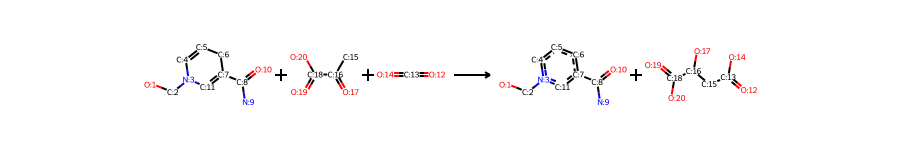

In [94]:
AllChem.ReactionFromSmarts(res['reaction_smarts'])

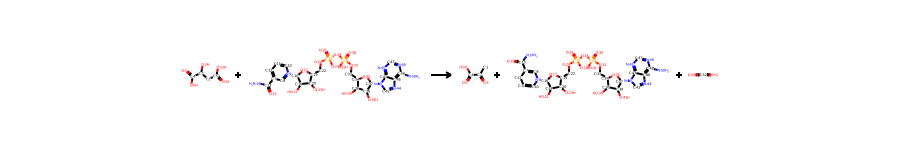

In [95]:
AllChem.ReactionFromSmarts(sma, useSmiles=True)

In [96]:
rhs_mol = Chem.MolFromSmiles(lhs)
matches = rhs_mol.GetSubstructMatches(Chem.MolFromSmarts(res['reactants']))
matches

((18, 17, 16, 15, 14, 13, 12, 10, 9, 11, 52, 0, 1, 2, 3, 4, 5, 6, 7, 8),)

In [97]:
y_pred = get_rdchiral_preds(res['reactants'], lhs, y)

In [98]:
for name, metric in metrics.items():
    print(f"{name}: {metric(y, y_pred)}")

precision: 0.65
recall: 1.0
accuracy: 0.8679245283018868
f1: 0.7878787878787878
